## Universidad Nacional de Chimborazo

**Facultad:** Facultad de Ingeniería  
**Carrera:** Ciencia de Datos e IA  
**Materia:** Modelamiento  
**Docente:** Estalin Mejia H.  
**Semestre:** Tercero

---

### Trabajo Autónomo 2

### Análisis de Regresión Lineal Múltiple: Predicción de Tarifas de Taxis en Nueva York

**Autores:**  
- Alisson Atupaña
- Mario Camacho
- Lenin Lopez

**Fecha:** 26 de octubre de 2025

**Riobamba - Ecuador**

---


<div style="display:flex; align-items:flex-start; gap:14px; background:linear-gradient(90deg,#123f6b,#154360); padding:18px; border-radius:12px; box-shadow:0 8px 20px rgba(21,67,96,0.25); color:#fff; max-width:720px; width:min(720px,100%); margin:12px auto; box-sizing:border-box;">
    <div style="width:36px; height:36px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.06); border-radius:8px; font-size:1rem; line-height:1;">📦</div>
    <div>
        <div style="font-weight:800; font-size:1.45rem; letter-spacing:0.4px;">Instalación de librerías</div>
        <div style="opacity:0.95; font-size:0.92rem; margin-top:4px;">Paquetes necesarios para lectura, manipulación y visualización de datos (ejecutar instalación solo la primera vez).</div>
    </div>
</div>

In [2]:
install.packages(c("readr", "dplyr", "ggplot2", "car", "GGally", "gridExtra", "psych"), verbose = FALSE, quiet = TRUE)

Warning message:
"packages 'readr', 'dplyr', 'ggplot2', 'car', 'GGally', 'gridExtra' are in use and will not be installed"


package 'psych' successfully unpacked and MD5 sums checked


<div style="display:flex; align-items:flex-start; gap:14px; background:linear-gradient(90deg,#123f6b,#154360); padding:18px; border-radius:12px; box-shadow:0 8px 20px rgba(21,67,96,0.25); color:#fff; max-width:720px; width:min(720px,100%); margin:12px auto; box-sizing:border-box;">
    <div style="width:36px; height:36px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.06); border-radius:8px; font-size:1rem; line-height:1;">📦</div>
    <div>
        <div style="font-weight:800; font-size:1.45rem; letter-spacing:0.4px;">Carga de librerías</div>
        <div style="opacity:0.95; font-size:0.92rem; margin-top:4px;"></div>
    </div>
</div>

In [1]:
library(readr) # para leer los datos
library(dplyr) # para manipulación de datos
library(ggplot2) # para visualización de los datos
library(car) # para análisis de regresión lineal
library(GGally) # para gráficos correlacionales
library(gridExtra) # para organizar múltiples gráficos


Adjuntando el paquete: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Cargando paquete requerido: carData


Adjuntando el paquete: 'car'


The following object is masked from 'package:dplyr':

    recode



Adjuntando el paquete: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




<div style="display:flex; align-items:flex-start; gap:14px; background:linear-gradient(90deg,#123f6b,#154360); padding:18px; border-radius:12px; box-shadow:0 8px 20px rgba(21,67,96,0.25); color:#fff; max-width:720px; width:min(720px,100%); margin:12px auto; box-sizing:border-box;">
    <div style="width:36px; height:36px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.06); border-radius:8px; font-size:1rem; line-height:1;">📦</div>
    <div>
        <div style="font-weight:800; font-size:1.45rem; letter-spacing:0.4px;">Carga y exploración de datos</div>
        <div style="opacity:0.95; font-size:0.92rem; margin-top:4px;">La exploración de los datos ayudará a comprender mejor su estructura y contenido.</div>
    </div>
</div>

In [2]:
datos <- readRDS("datos.rds")

In [3]:
head(datos)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,RatecodeID
<dbl>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,2016-03-27 21:14:57,2016-03-27 21:20:27,1,1.12,-73.98667,40.72813,NA,N,-73.98641,40.73848,1,6.0,0.5,0.5,1.46,0,0.3,8.76,1
2,2016-02-20 18:15:45,2016-02-20 18:46:13,1,3.80,-73.98663,40.77701,NA,N,-74.00238,40.73035,1,19.5,0.0,0.5,1.50,0,0.3,21.80,1
2,2016-01-02 17:26:54,2016-01-02 17:31:58,2,0.73,-73.97395,40.76041,NA,N,-73.96369,40.75890,1,5.5,0.0,0.5,1.00,0,0.3,7.30,1
1,2016-01-29 14:13:50,2016-01-29 14:29:41,1,2.00,-73.98127,40.75839,NA,N,-73.98635,40.77897,1,11.5,0.0,0.5,1.50,0,0.3,13.80,1
2,2015-01-04 19:55:27,2015-01-04 20:00:53,1,0.78,-74.00253,40.75269,1,N,-73.99132,40.75177,1,5.5,0.0,0.5,1.10,0,0.3,7.40,NA
1,2015-01-15 13:23:40,2015-01-15 13:35:18,1,1.90,-73.98387,40.78062,1,N,-73.96466,40.76981,1,9.5,0.0,0.5,2.05,0,0.3,12.35,NA


In [4]:
glimpse(datos, width = 50)

Rows: 2,000,000
Columns: 20
$ VendorID              <dbl> 2, 2, 2, 1, 2, 1, …
$ tpep_pickup_datetime  <dttm> 2016-03-27 21:14:…
$ tpep_dropoff_datetime <dttm> 2016-03-27 21:20:…
$ passenger_count       <dbl> 1, 1, 2, 1, 1, 1, …
$ trip_distance         <dbl> 1.12, 3.80, 0.73, …
$ pickup_longitude      <dbl> -73.98667, -73.986…
$ pickup_latitude       <dbl> 40.72813, 40.77701…
$ RateCodeID            <dbl> NA, NA, NA, NA, 1,…
$ store_and_fwd_flag    <chr> "N", "N", "N", "N"…
$ dropoff_longitude     <dbl> -73.98641, -74.002…
$ dropoff_latitude      <dbl> 40.73848, 40.73035…
$ payment_type          <dbl> 1, 1, 1, 1, 1, 1, …
$ fare_amount           <dbl> 6.0, 19.5, 5.5, 11…
$ extra                 <dbl> 0.5, 0.0, 0.0, 0.0…
$ mta_tax               <dbl> 0.5, 0.5, 0.5, 0.5…
$ tip_amount            <dbl> 1.46, 1.50, 1.00, …
$ tolls_amount          <dbl> 0, 0, 0, 0, 0, 0, …
$ improvement_surcharge <dbl> 0.3, 0.3, 0.3, 0.3…
$ total_amount          <dbl> 8.76, 21.80, 7.30,…
$ RatecodeID          

In [5]:
summary(datos)

    VendorID    tpep_pickup_datetime          tpep_dropoff_datetime        
 Min.   :1.00   Min.   :2015-01-01 00:00:00   Min.   :2015-01-01 00:00:00  
 1st Qu.:1.00   1st Qu.:2015-01-30 07:25:51   1st Qu.:2015-01-30 07:38:03  
 Median :2.00   Median :2016-01-31 19:41:59   Median :2016-01-31 19:58:15  
 Mean   :1.53   Mean   :2015-11-01 17:10:40   Mean   :2015-11-01 17:26:00  
 3rd Qu.:2.00   3rd Qu.:2016-03-02 02:54:46   3rd Qu.:2016-03-02 03:11:47  
 Max.   :2.00   Max.   :2016-03-31 23:59:59   Max.   :2016-06-17 22:07:31  
                                                                           
 passenger_count trip_distance      pickup_longitude  pickup_latitude
 Min.   :0.000   Min.   :0.00e+00   Min.   :-131.82   Min.   : 0.00  
 1st Qu.:1.000   1st Qu.:1.00e+00   1st Qu.: -73.99   1st Qu.:40.74  
 Median :1.000   Median :1.70e+00   Median : -73.98   Median :40.75  
 Mean   :1.667   Mean   :5.10e+00   Mean   : -72.77   Mean   :40.09  
 3rd Qu.:2.000   3rd Qu.:3.10e+00   3rd Qu

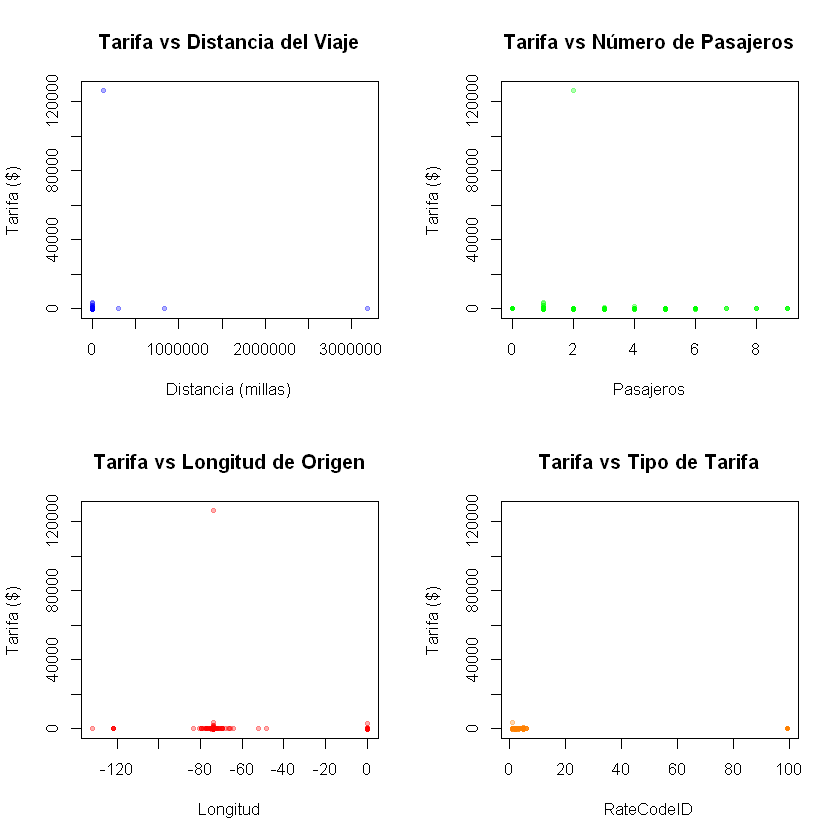

In [11]:
par(mfrow = c(2, 2))

# 1. Relación más importante: distancia vs tarifa
plot(datos$trip_distance, datos$fare_amount,
     main = "Tarifa vs Distancia del Viaje",
     xlab = "Distancia (millas)", ylab = "Tarifa ($)",
     pch = 20, col = rgb(0, 0, 1, 0.3))

# 2. Pasajeros vs tarifa
plot(datos$passenger_count, datos$fare_amount,
     main = "Tarifa vs Número de Pasajeros",
     xlab = "Pasajeros", ylab = "Tarifa ($)",
     pch = 20, col = rgb(0, 1, 0, 0.3))

# 3. Longitud vs tarifa
plot(datos$pickup_longitude, datos$fare_amount,
     main = "Tarifa vs Longitud de Origen",
     xlab = "Longitud", ylab = "Tarifa ($)",
     pch = 20, col = rgb(1, 0, 0, 0.3))

# 4. RateCodeID vs tarifa
plot(datos$RateCodeID, datos$fare_amount,
     main = "Tarifa vs Tipo de Tarifa",
     xlab = "RateCodeID", ylab = "Tarifa ($)",
     pch = 20, col = rgb(1, 0.5, 0, 0.3))

par(mfrow = c(1, 1))